# Sistema de Recomendação de Cartões de Crédito

Este notebook tem como objetivo

1. Desenvolver um modelo preditivo para classificação do principal cartão para clientes
2. Aplicar o modelo de clientes na base prospects
3. Gerar arquivo final com cartão ideal (recomendação para prospects)

In [ ]:
# pipenv install pandas plotly catboost matplotlib seaborn scipy ipykernel scikit-learn optuna colorama nbformat lightgbm
# EDA e Visualização de Dados

import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from colorama import Fore, Back, Style

# Configurar formato de exibição para não usar notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True, precision=5)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from catboost import CatBoostClassifier, Pool, cv

# Otimização
import optuna

# Utilitários
import joblib
import math

### Abrir Base Clientes

In [2]:
df_clients = pd.read_csv('./datasets/clients.csv')

In [3]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Cliente                   1000 non-null   object 
 1   Nome                         1000 non-null   object 
 2   Idade                        1000 non-null   int64  
 3   Viagens                      1000 non-null   int64  
 4   Restaurantes                 1000 non-null   int64  
 5   Entretenimento               1000 non-null   int64  
 6   Cashback                     1000 non-null   int64  
 7   Compras online               1000 non-null   int64  
 8   Farmácias                    1000 non-null   int64  
 9   Programas de Milhagem        1000 non-null   int64  
 10  Postos de Combustível        1000 non-null   int64  
 11  Mercados                     1000 non-null   int64  
 12  Cidade                       1000 non-null   object 
 13  Cargo              

In [4]:
# Remover colunas únicas
df_clients.drop(columns=['ID_Cliente', 'Nome'], axis=1, inplace=True)

In [5]:
num_vars = df_clients.select_dtypes(include=['number']).columns
cat_vars = df_clients.select_dtypes(include=['object']).columns
target = 'Principal Cartão'

### Teste de Hipóteses

In [6]:
# Testes de hipóteses entre Target Categórica e Numéricas (ANOVA)

for num_col in num_vars:
  groups = (df_clients[df_clients[target]== val][num_col] for val in df_clients[target].unique())

  stat, p = f_oneway(*groups)
  print(f'{Fore.RED if p<0.05 else Fore.WHITE}'
        f'ANOVA ENTRE {num_col} e {target}: p-valor = {p}'
        )

ANOVA ENTRE Idade e Principal Cartão: p-valor = 0.023346226841078038
ANOVA ENTRE Viagens e Principal Cartão: p-valor = 4.59308651849609e-78
ANOVA ENTRE Restaurantes e Principal Cartão: p-valor = 6.679790462858738e-13
ANOVA ENTRE Entretenimento e Principal Cartão: p-valor = 5.089212006248722e-18
ANOVA ENTRE Cashback e Principal Cartão: p-valor = 8.77437441029354e-12
ANOVA ENTRE Compras online e Principal Cartão: p-valor = 0.00717148660617559
ANOVA ENTRE Farmácias e Principal Cartão: p-valor = 0.0006390735697304401
ANOVA ENTRE Programas de Milhagem e Principal Cartão: p-valor = 0.001269305962592174
ANOVA ENTRE Postos de Combustível e Principal Cartão: p-valor = 0.11255638879254316
ANOVA ENTRE Mercados e Principal Cartão: p-valor = 0.03415290834272708
ANOVA ENTRE Tempo na Empresa e Principal Cartão: p-valor = 0.32092370365000267
ANOVA ENTRE Pessoas em Casa e Principal Cartão: p-valor = 0.059466414559887854
ANOVA ENTRE Renda e Principal Cartão: p-valor = 1.5360217142979347e-34
ANOVA ENTRE 

In [7]:
# Analisando relação entre variáveis explicativas e targets

for col in num_vars:
  fig = px.box(df_clients, x=target, y=col, title=f'{col} por {target}')
  fig.show()

for col in cat_vars:
  fig = px.histogram(df_clients, x=col, color=target, barmode='group', title=f'{col} por {target}')
  fig.show()


### Modelo Catboost com Validação Cruzada

In [10]:
selected_features = ['Viagens', 'Restaurantes', 'Entretenimento', 'Cashback', 'Compras online', 'Farmácias', 'Programas de Milhagem', 'Postos de Combustível', 'Mercados', 'Score']

X = df_clients[selected_features]
y = df_clients[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Definir os parâmetros do modelo
params = {
  'iterations': 1000,
  'learning_rate': 0.05,
  'depth': 6,
  'l2_leaf_reg': 3,
  'random_strength': 2,
  'loss_function': 'MultiClass', # Use 'MultiClass para problemas de classificação multiclasse
  'eval_metric': 'MultiClass'
}

model = CatBoostClassifier(**params, random_seed=42, auto_class_weights='Balanced')

model.fit(X_train, y_train)

# Obter log loss médio
best_score = model.best_score_['learn']['MultiClass']
print(f'LogLoss no treinamento: {best_score}')

0:	learn: 3.1361616	total: 157ms	remaining: 2m 37s
1:	learn: 3.0966905	total: 176ms	remaining: 1m 27s
2:	learn: 3.0415708	total: 198ms	remaining: 1m 5s
3:	learn: 2.9918112	total: 215ms	remaining: 53.6s
4:	learn: 2.9479092	total: 229ms	remaining: 45.6s
5:	learn: 2.9060745	total: 243ms	remaining: 40.3s
6:	learn: 2.8958633	total: 247ms	remaining: 35s
7:	learn: 2.8461542	total: 260ms	remaining: 32.3s
8:	learn: 2.8098443	total: 273ms	remaining: 30.1s
9:	learn: 2.7748998	total: 286ms	remaining: 28.3s
10:	learn: 2.7366319	total: 299ms	remaining: 26.8s
11:	learn: 2.7120453	total: 311ms	remaining: 25.6s
12:	learn: 2.6740911	total: 323ms	remaining: 24.5s
13:	learn: 2.6420074	total: 329ms	remaining: 23.2s
14:	learn: 2.6062796	total: 343ms	remaining: 22.5s
15:	learn: 2.5769803	total: 356ms	remaining: 21.9s
16:	learn: 2.5486886	total: 369ms	remaining: 21.3s
17:	learn: 2.5133635	total: 386ms	remaining: 21s
18:	learn: 2.4873181	total: 402ms	remaining: 20.7s
19:	learn: 2.4615481	total: 418ms	remaining

In [12]:
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)

test_loss = log_loss(y_test, probs)
print(f'LogLoss no conjunto de teste: {test_loss:.2f}')

LogLoss no conjunto de teste: 1.46


### Otimizar com Optuna

In [20]:
# Definir a função objetivo para otimização
def objective(trial):
  # Definir o espaço de busca para hiperparâmetros
  params = {
    'iterations': trial.suggest_int('iterations', 100, 1000),
    'depth': trial.suggest_int('depth', 4, 10),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
    'random_strength': trial.suggest_uniform('random_strength', 0, 10),
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass'
  }

  model = CatBoostClassifier(**params, random_state=42, auto_class_weights='Balanced')

  model.fit(X_train, y_train)

  best_score = model.best_score_['learn']['MultiClass']
  return best_score


# Criar um estudo e otimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) # Ajustar o número de trials conforme necessário

# Obter os melhores parâmetros
best_params = study.best_params
best_metric = study.best_value
print('Melhores parâmetros:', best_params)
print('Melhor métrica:', best_metric)


[I 2025-04-09 11:52:56,050] A new study created in memory with name: no-name-50e5077a-93dd-4a24-bb21-3ab72c8624d8
C:\Users\felipe.fardo\AppData\Local\Temp\ipykernel_16452\2424587133.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\felipe.fardo\AppData\Local\Temp\ipykernel_16452\2424587133.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\felipe.fardo\AppData\Local\Temp\ipykernel_16452\2424587133.py:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



0:	learn: 3.1581071	total: 5.26ms	remaining: 2.62s
1:	learn: 3.1305431	total: 8.51ms	remaining: 2.11s
2:	learn: 3.0844319	total: 11.4ms	remaining: 1.88s
3:	learn: 3.0503551	total: 14.7ms	remaining: 1.81s
4:	learn: 3.0208739	total: 17.8ms	remaining: 1.76s
5:	learn: 2.9909802	total: 21ms	remaining: 1.72s
6:	learn: 2.9722974	total: 24ms	remaining: 1.68s
7:	learn: 2.9494377	total: 27.6ms	remaining: 1.69s
8:	learn: 2.9281723	total: 31.5ms	remaining: 1.71s
9:	learn: 2.9079601	total: 34.7ms	remaining: 1.69s
10:	learn: 2.8878572	total: 39ms	remaining: 1.73s
11:	learn: 2.8626751	total: 42.2ms	remaining: 1.71s
12:	learn: 2.8450235	total: 45.4ms	remaining: 1.69s
13:	learn: 2.8299572	total: 48.2ms	remaining: 1.67s
14:	learn: 2.8065481	total: 51.3ms	remaining: 1.65s
15:	learn: 2.7967535	total: 54.3ms	remaining: 1.63s
16:	learn: 2.7772891	total: 57.4ms	remaining: 1.62s
17:	learn: 2.7545298	total: 60.4ms	remaining: 1.61s
18:	learn: 2.7279549	total: 63.5ms	remaining: 1.6s
19:	learn: 2.7037276	total: 6

[I 2025-04-09 11:52:57,885] Trial 0 finished with value: 0.45446462670618676 and parameters: {'iterations': 498, 'depth': 4, 'learning_rate': 0.05588385404665346, 'l2_leaf_reg': 6.980633907266111, 'random_strength': 2.7596865654287117}. Best is trial 0 with value: 0.45446462670618676.


464:	learn: 0.4784028	total: 1.57s	remaining: 111ms
465:	learn: 0.4776950	total: 1.57s	remaining: 108ms
466:	learn: 0.4768054	total: 1.57s	remaining: 104ms
467:	learn: 0.4759481	total: 1.57s	remaining: 101ms
468:	learn: 0.4754176	total: 1.58s	remaining: 97.6ms
469:	learn: 0.4746879	total: 1.58s	remaining: 94.2ms
470:	learn: 0.4740504	total: 1.58s	remaining: 90.9ms
471:	learn: 0.4730917	total: 1.59s	remaining: 87.5ms
472:	learn: 0.4725965	total: 1.59s	remaining: 84.1ms
473:	learn: 0.4719078	total: 1.59s	remaining: 80.8ms
474:	learn: 0.4709889	total: 1.6s	remaining: 77.4ms
475:	learn: 0.4703591	total: 1.6s	remaining: 74ms
476:	learn: 0.4695454	total: 1.6s	remaining: 70.7ms
477:	learn: 0.4687245	total: 1.61s	remaining: 67.3ms
478:	learn: 0.4679100	total: 1.61s	remaining: 64ms
479:	learn: 0.4671543	total: 1.61s	remaining: 60.6ms
480:	learn: 0.4663183	total: 1.62s	remaining: 57.2ms
481:	learn: 0.4655451	total: 1.62s	remaining: 53.9ms
482:	learn: 0.4648679	total: 1.63s	remaining: 50.5ms
483:

[I 2025-04-09 11:53:16,603] Trial 1 finished with value: 0.31957374489129536 and parameters: {'iterations': 763, 'depth': 7, 'learning_rate': 0.01778222046109802, 'l2_leaf_reg': 2.521048366741841, 'random_strength': 2.3428303093743006}. Best is trial 0 with value: 0.45446462670618676.


759:	learn: 0.3209141	total: 18.2s	remaining: 72ms
760:	learn: 0.3205107	total: 18.3s	remaining: 48ms
761:	learn: 0.3200489	total: 18.3s	remaining: 24ms
762:	learn: 0.3195737	total: 18.3s	remaining: 0us
0:	learn: 3.1664242	total: 43.1ms	remaining: 7.4s
1:	learn: 3.1528226	total: 77.4ms	remaining: 6.62s
2:	learn: 3.1399076	total: 107ms	remaining: 6.08s
3:	learn: 3.1300556	total: 114ms	remaining: 4.83s
4:	learn: 3.1184689	total: 138ms	remaining: 4.65s
5:	learn: 3.1105267	total: 145ms	remaining: 4.05s
6:	learn: 3.0990630	total: 174ms	remaining: 4.12s
7:	learn: 3.0878537	total: 200ms	remaining: 4.13s
8:	learn: 3.0768151	total: 225ms	remaining: 4.1s
9:	learn: 3.0683933	total: 229ms	remaining: 3.73s
10:	learn: 3.0564379	total: 255ms	remaining: 3.75s
11:	learn: 3.0434775	total: 283ms	remaining: 3.8s
12:	learn: 3.0365860	total: 286ms	remaining: 3.52s
13:	learn: 3.0247848	total: 324ms	remaining: 3.68s
14:	learn: 3.0151969	total: 351ms	remaining: 3.69s
15:	learn: 3.0037776	total: 384ms	remaining

[I 2025-04-09 11:53:20,720] Trial 2 finished with value: 1.9526409972154923 and parameters: {'iterations': 173, 'depth': 7, 'learning_rate': 0.026218140512824648, 'l2_leaf_reg': 7.881862246133583, 'random_strength': 3.0718476986153895}. Best is trial 2 with value: 1.9526409972154923.


0:	learn: 3.1656988	total: 61.6ms	remaining: 22s
1:	learn: 3.1525566	total: 145ms	remaining: 25.9s
2:	learn: 3.1396617	total: 189ms	remaining: 22.4s
3:	learn: 3.1258550	total: 228ms	remaining: 20.3s
4:	learn: 3.1135306	total: 240ms	remaining: 17s
5:	learn: 3.1017954	total: 283ms	remaining: 16.6s
6:	learn: 3.0892643	total: 339ms	remaining: 17s
7:	learn: 3.0777795	total: 379ms	remaining: 16.6s
8:	learn: 3.0655626	total: 423ms	remaining: 16.4s
9:	learn: 3.0526602	total: 464ms	remaining: 16.2s
10:	learn: 3.0407514	total: 505ms	remaining: 16s
11:	learn: 3.0294437	total: 564ms	remaining: 16.3s
12:	learn: 3.0173117	total: 610ms	remaining: 16.2s
13:	learn: 3.0065223	total: 652ms	remaining: 16.1s
14:	learn: 2.9951724	total: 692ms	remaining: 15.9s
15:	learn: 2.9829227	total: 737ms	remaining: 15.8s
16:	learn: 2.9723329	total: 790ms	remaining: 15.9s
17:	learn: 2.9608391	total: 832ms	remaining: 15.8s
18:	learn: 2.9495489	total: 875ms	remaining: 15.7s
19:	learn: 2.9381142	total: 916ms	remaining: 15.

[I 2025-04-09 11:53:36,968] Trial 3 finished with value: 1.1113510983887471 and parameters: {'iterations': 359, 'depth': 8, 'learning_rate': 0.02849915538894954, 'l2_leaf_reg': 8.346277501858381, 'random_strength': 1.4513761801339953}. Best is trial 2 with value: 1.9526409972154923.


0:	learn: 3.1024784	total: 96.6ms	remaining: 50.1s
1:	learn: 3.0293088	total: 174ms	remaining: 45s
2:	learn: 2.9656619	total: 216ms	remaining: 37.2s
3:	learn: 2.9165863	total: 242ms	remaining: 31.2s
4:	learn: 2.8806417	total: 248ms	remaining: 25.5s
5:	learn: 2.8280252	total: 337ms	remaining: 28.8s
6:	learn: 2.7805269	total: 377ms	remaining: 27.6s
7:	learn: 2.7321040	total: 495ms	remaining: 31.6s
8:	learn: 2.6797943	total: 620ms	remaining: 35.1s
9:	learn: 2.6279131	total: 677ms	remaining: 34.4s
10:	learn: 2.5779989	total: 767ms	remaining: 35.4s
11:	learn: 2.5409954	total: 824ms	remaining: 34.8s
12:	learn: 2.5202043	total: 829ms	remaining: 32.3s
13:	learn: 2.4799538	total: 946ms	remaining: 34.1s
14:	learn: 2.4396963	total: 1.05s	remaining: 35.4s
15:	learn: 2.3971908	total: 1.19s	remaining: 37.3s
16:	learn: 2.3511157	total: 1.35s	remaining: 39.8s
17:	learn: 2.3118033	total: 1.49s	remaining: 41.5s
18:	learn: 2.2751344	total: 1.61s	remaining: 42.3s
19:	learn: 2.2604174	total: 1.62s	remainin

[I 2025-04-09 11:54:20,401] Trial 4 finished with value: 0.10445818698460307 and parameters: {'iterations': 519, 'depth': 9, 'learning_rate': 0.03335657374368001, 'l2_leaf_reg': 1.063441827003452, 'random_strength': 9.069529140607758}. Best is trial 2 with value: 1.9526409972154923.


0:	learn: 3.0934344	total: 59.3ms	remaining: 28.1s
1:	learn: 3.0110210	total: 105ms	remaining: 24.8s
2:	learn: 2.9317860	total: 149ms	remaining: 23.4s
3:	learn: 2.9196569	total: 150ms	remaining: 17.7s
4:	learn: 2.8500744	total: 200ms	remaining: 18.7s
5:	learn: 2.8233595	total: 205ms	remaining: 16s
6:	learn: 2.7628140	total: 256ms	remaining: 17.1s
7:	learn: 2.7037201	total: 315ms	remaining: 18.3s
8:	learn: 2.6503516	total: 385ms	remaining: 19.9s
9:	learn: 2.6015939	total: 428ms	remaining: 19.9s
10:	learn: 2.5431071	total: 468ms	remaining: 19.7s
11:	learn: 2.4958330	total: 509ms	remaining: 19.6s
12:	learn: 2.4587763	total: 513ms	remaining: 18.2s
13:	learn: 2.4212732	total: 533ms	remaining: 17.5s
14:	learn: 2.3931394	total: 537ms	remaining: 16.4s
15:	learn: 2.3551071	total: 591ms	remaining: 16.9s
16:	learn: 2.3164203	total: 635ms	remaining: 17.1s
17:	learn: 2.3019678	total: 642ms	remaining: 16.3s
18:	learn: 2.2665712	total: 664ms	remaining: 15.9s
19:	learn: 2.2331430	total: 687ms	remainin

[I 2025-04-09 11:54:40,428] Trial 5 finished with value: 0.10686314280408103 and parameters: {'iterations': 474, 'depth': 8, 'learning_rate': 0.07688680142920613, 'l2_leaf_reg': 2.795348718751762, 'random_strength': 7.691973872660331}. Best is trial 2 with value: 1.9526409972154923.


471:	learn: 0.1074449	total: 19.7s	remaining: 83.3ms
472:	learn: 0.1071412	total: 19.7s	remaining: 41.6ms
473:	learn: 0.1068631	total: 19.7s	remaining: 0us
0:	learn: 3.1692789	total: 187ms	remaining: 43.2s
1:	learn: 3.1600211	total: 280ms	remaining: 32.2s
2:	learn: 3.1513325	total: 329ms	remaining: 25.1s
3:	learn: 3.1431471	total: 351ms	remaining: 20s
4:	learn: 3.1355602	total: 359ms	remaining: 16.3s
5:	learn: 3.1266659	total: 465ms	remaining: 17.5s
6:	learn: 3.1182889	total: 492ms	remaining: 15.8s
7:	learn: 3.1099342	total: 576ms	remaining: 16.1s
8:	learn: 3.1011721	total: 655ms	remaining: 16.2s
9:	learn: 3.0908115	total: 700ms	remaining: 15.5s
10:	learn: 3.0813243	total: 803ms	remaining: 16.1s
11:	learn: 3.0732492	total: 894ms	remaining: 16.4s
12:	learn: 3.0679290	total: 896ms	remaining: 15.1s
13:	learn: 3.0598400	total: 1s	remaining: 15.6s
14:	learn: 3.0516000	total: 1.11s	remaining: 16s
15:	learn: 3.0431539	total: 1.19s	remaining: 16.1s
16:	learn: 3.0334584	total: 1.31s	remaining: 

[I 2025-04-09 11:54:56,309] Trial 6 finished with value: 1.9779161128620102 and parameters: {'iterations': 232, 'depth': 9, 'learning_rate': 0.016065112555934284, 'l2_leaf_reg': 6.520459320635262, 'random_strength': 3.447883226566415}. Best is trial 6 with value: 1.9779161128620102.


228:	learn: 1.9817045	total: 15.7s	remaining: 205ms
229:	learn: 1.9799462	total: 15.7s	remaining: 136ms
230:	learn: 1.9791735	total: 15.7s	remaining: 67.8ms
231:	learn: 1.9779161	total: 15.7s	remaining: 0us
0:	learn: 3.0592814	total: 279ms	remaining: 2m 54s
1:	learn: 2.9427306	total: 502ms	remaining: 2m 37s
2:	learn: 2.8647335	total: 523ms	remaining: 1m 49s
3:	learn: 2.7974609	total: 568ms	remaining: 1m 28s
4:	learn: 2.7389932	total: 579ms	remaining: 1m 12s
5:	learn: 2.6657006	total: 698ms	remaining: 1m 12s
6:	learn: 2.5999141	total: 725ms	remaining: 1m 4s
7:	learn: 2.5348745	total: 861ms	remaining: 1m 6s
8:	learn: 2.4653664	total: 1.11s	remaining: 1m 16s
9:	learn: 2.3937752	total: 1.14s	remaining: 1m 10s
10:	learn: 2.3291357	total: 1.38s	remaining: 1m 17s
11:	learn: 2.2867528	total: 1.41s	remaining: 1m 12s
12:	learn: 2.2569638	total: 1.42s	remaining: 1m 7s
13:	learn: 2.2071673	total: 1.67s	remaining: 1m 13s
14:	learn: 2.1591318	total: 1.73s	remaining: 1m 10s
15:	learn: 2.1049917	total

[I 2025-04-09 11:56:43,030] Trial 7 finished with value: 0.04382964852168218 and parameters: {'iterations': 629, 'depth': 10, 'learning_rate': 0.06406263323220782, 'l2_leaf_reg': 1.424621645538404, 'random_strength': 9.979478034443597}. Best is trial 6 with value: 1.9779161128620102.


0:	learn: 3.1284338	total: 193ms	remaining: 2m 49s
1:	learn: 3.0768460	total: 360ms	remaining: 2m 37s
2:	learn: 3.0366453	total: 372ms	remaining: 1m 48s
3:	learn: 2.9980165	total: 392ms	remaining: 1m 25s
4:	learn: 2.9665067	total: 398ms	remaining: 1m 9s
5:	learn: 2.9217900	total: 585ms	remaining: 1m 24s
6:	learn: 2.8846724	total: 669ms	remaining: 1m 23s
7:	learn: 2.8512566	total: 677ms	remaining: 1m 13s
8:	learn: 2.8137289	total: 857ms	remaining: 1m 22s
9:	learn: 2.7717821	total: 913ms	remaining: 1m 19s
10:	learn: 2.7324034	total: 1.1s	remaining: 1m 26s
11:	learn: 2.7045192	total: 1.13s	remaining: 1m 21s
12:	learn: 2.6847644	total: 1.13s	remaining: 1m 15s
13:	learn: 2.6535253	total: 1.3s	remaining: 1m 20s
14:	learn: 2.6231679	total: 1.36s	remaining: 1m 17s
15:	learn: 2.5888789	total: 1.45s	remaining: 1m 17s
16:	learn: 2.5519433	total: 1.52s	remaining: 1m 17s
17:	learn: 2.5214556	total: 1.7s	remaining: 1m 21s
18:	learn: 2.4922467	total: 1.86s	remaining: 1m 24s
19:	learn: 2.4640191	total

[I 2025-04-09 11:59:03,511] Trial 8 finished with value: 0.09880824312001613 and parameters: {'iterations': 876, 'depth': 10, 'learning_rate': 0.04097320089363476, 'l2_leaf_reg': 2.544502404814405, 'random_strength': 4.405654902752374}. Best is trial 6 with value: 1.9779161128620102.


0:	learn: 3.1518920	total: 5.58ms	remaining: 2.94s
1:	learn: 3.1141771	total: 12.4ms	remaining: 3.25s
2:	learn: 3.1074283	total: 14.5ms	remaining: 2.53s
3:	learn: 3.0697587	total: 20.1ms	remaining: 2.62s
4:	learn: 3.0333461	total: 24.7ms	remaining: 2.58s
5:	learn: 2.9929693	total: 30ms	remaining: 2.61s
6:	learn: 2.9703356	total: 33.1ms	remaining: 2.46s
7:	learn: 2.9476303	total: 37.9ms	remaining: 2.46s
8:	learn: 2.9088400	total: 42.7ms	remaining: 2.46s
9:	learn: 2.8842100	total: 46ms	remaining: 2.38s
10:	learn: 2.8581129	total: 50ms	remaining: 2.35s
11:	learn: 2.8374738	total: 52.6ms	remaining: 2.26s
12:	learn: 2.8315784	total: 53.9ms	remaining: 2.13s
13:	learn: 2.8083509	total: 56.7ms	remaining: 2.08s
14:	learn: 2.7815505	total: 59.3ms	remaining: 2.02s
15:	learn: 2.7574630	total: 63.2ms	remaining: 2.02s
16:	learn: 2.7362792	total: 66ms	remaining: 1.98s
17:	learn: 2.7004524	total: 69.7ms	remaining: 1.97s
18:	learn: 2.6830617	total: 73.3ms	remaining: 1.96s
19:	learn: 2.6618640	total: 76

[I 2025-04-09 11:59:05,431] Trial 9 finished with value: 0.3349408732268456 and parameters: {'iterations': 527, 'depth': 4, 'learning_rate': 0.031798546308217136, 'l2_leaf_reg': 1.683139549293168, 'random_strength': 5.189906925490634}. Best is trial 6 with value: 1.9779161128620102.


526:	learn: 0.3349409	total: 1.75s	remaining: 0us
Melhores parâmetros: {'iterations': 232, 'depth': 9, 'learning_rate': 0.016065112555934284, 'l2_leaf_reg': 6.520459320635262, 'random_strength': 3.447883226566415}
Melhor métrica: 1.9779161128620102


In [21]:
# Treinar o modelo final com os parãmetros otimizados
best_model = CatBoostClassifier(**best_params, verbose=False, random_seed=42)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)
test_loss = log_loss(y_test, probs)
print(f'LogLoss no conjunto de teste: {test_loss:.2f}')

LogLoss no conjunto de teste: 2.60



Relatório de Classificação
                                         precision    recall  f1-score   support

       Rocketseat Mastercard Life Basic       0.23      0.46      0.31        79
       Rocketseat Mastercard Life Elite       0.00      0.00      0.00        17
    Rocketseat Mastercard Life Platinum       0.00      0.00      0.00         1
      Rocketseat Mastercard Life Select       0.00      0.00      0.00        25
   Rocketseat Mastercard Shopping Basic       0.24      0.42      0.30        40
   Rocketseat Mastercard Shopping Elite       0.00      0.00      0.00         7
Rocketseat Mastercard Shopping Platinum       0.00      0.00      0.00         2
  Rocketseat Mastercard Shopping Select       0.14      0.07      0.10        14
     Rocketseat Mastercard Travel Basic       0.31      0.80      0.44        45
     Rocketseat Mastercard Travel Elite       0.00      0.00      0.00         9
  Rocketseat Mastercard Travel Platinum       0.00      0.00      0.00         3

c:\Users\felipe.fardo\.virtualenvs\challenge-VkipJ5TK\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\felipe.fardo\.virtualenvs\challenge-VkipJ5TK\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\felipe.fardo\.virtualenvs\challenge-VkipJ5TK\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



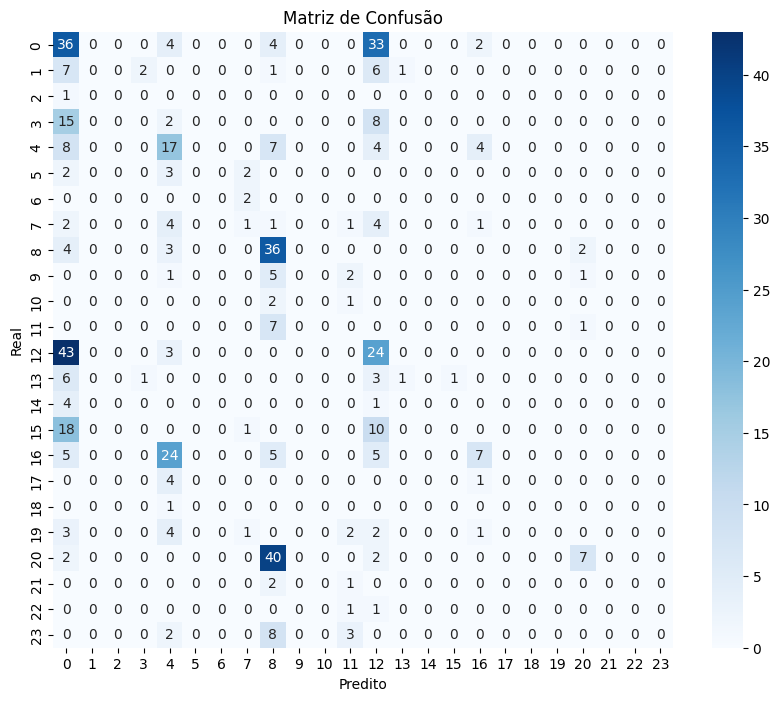

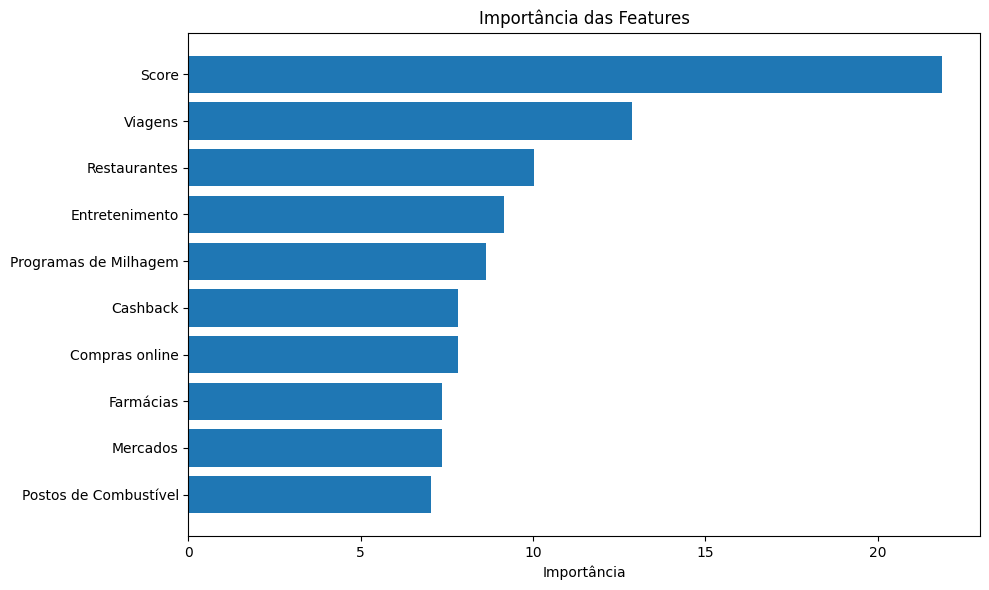

In [23]:
# Calcular e exibis métricas
print(f'\nRelatório de Classificação')
print(classification_report(y_test, y_pred))

# Criar matriz de confusão
plt.figure(figsize=(10,8))
conf_matriz = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matriz, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Plotar importância das features
plt.figure(figsize=(10,6))
feature_importance = pd.DataFrame({
  'feature': selected_features,
  'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Importância das Features')
plt.xlabel('Importância')

plt.tight_layout()
plt.show()

### Salvar Modelo

In [24]:
joblib.dump(best_model, 'model_recommendation.pkl')

['model_recommendation.pkl']

### Abrir Base Prospects com Score

In [25]:
# Carregar Prospects
df_prospects = pd.read_csv('./datasets/prospects_with_score.csv')

In [26]:
df_prospects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Prospect                  500 non-null    object 
 1   Nome                         500 non-null    object 
 2   Idade                        500 non-null    int64  
 3   Viagens                      500 non-null    int64  
 4   Restaurantes                 500 non-null    int64  
 5   Entretenimento               500 non-null    int64  
 6   Cashback                     500 non-null    int64  
 7   Compras online               500 non-null    int64  
 8   Farmácias                    500 non-null    int64  
 9   Programas de Milhagem        500 non-null    int64  
 10  Postos de Combustível        500 non-null    int64  
 11  Mercados                     500 non-null    int64  
 12  Cidade                       500 non-null    object 
 13  Cargo               

### Carregar Modelo

In [27]:
model = joblib.load('./model_recommendation.pkl')

### Preparar dados

In [28]:
# Preparar dados
selected_features = ['Viagens', 'Restaurantes', 'Entretenimento', 'Cashback', 'Compras online', 'Farmácias', 'Programas de Milhagem', 'Postos de Combustível', 'Mercados', 'Score']

X_prospects = df_prospects[selected_features]

In [29]:
# Fazer previsões
df_prospects['Principal Cartão'] = model.predict(X_prospects).squeeze()

### Salvar Resultados da Recomendação

In [31]:
# Salvar resultados
df_prospects.to_csv('./datasets/prospects_with_recommendation.csv', index=False)